In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm

import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
import torch.nn.functional as F

In [12]:
from torchvision.transforms import v2
torch.manual_seed(17)

transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(60),
    v2.ToDtype(torch.float32)
])


class NCaltech101ImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images = np.load(img_dir_file + '_x.npy')
        self.labels = np.load(img_dir_file + '_y.npy')
        self.transform = transform
        self.transform = transform
        self.stage = 0

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        # if self.target_transform:
        #     label = self.target_transform(label)
        label_temp = np.zeros((101,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
    
    def set_stage(self, stage):
        self.stage = stage

In [13]:
training_data = NCaltech101ImageDataset("./Datasety/Ncaltech101", transform=transforms)

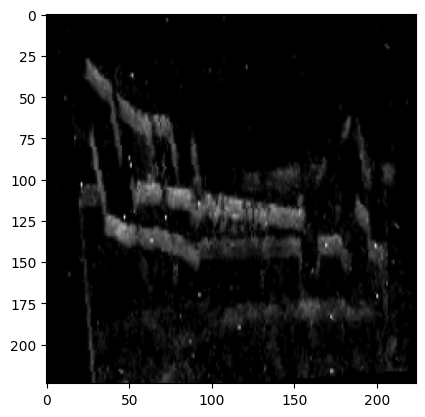

tensor(0.8586)


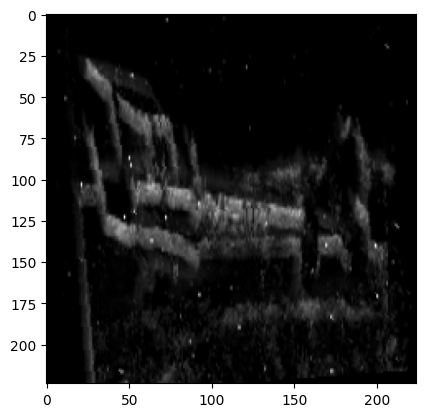

tensor(0.8586)


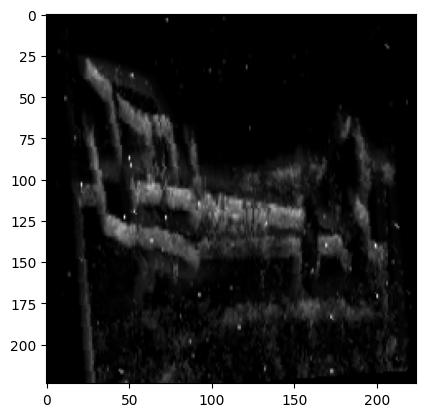

tensor(0.8587)


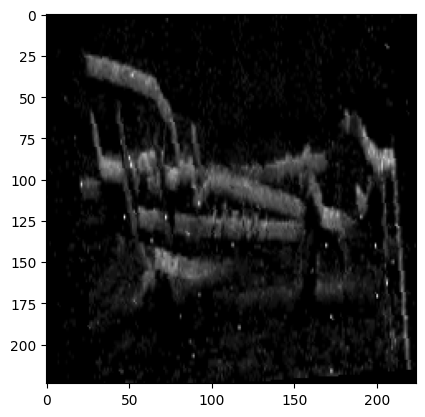

tensor(0.8586)


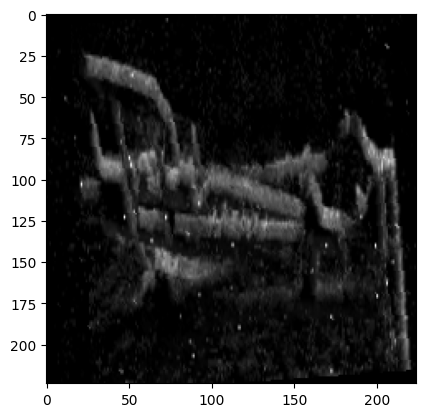

tensor(0.8587)


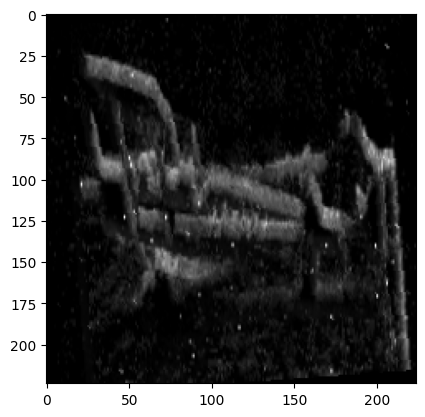

tensor(0.8588)


In [14]:
pic, label = training_data[100]

noBins = 3
for i in range(2*noBins):
    pic2 = pic[i,...]
    plt.gray()
    plt.imshow(pic2)
    plt.show()
    print(torch.max(pic2))

In [15]:
train_dataset, test_dataset = torch.utils.data.random_split(training_data, [0.8, 0.2])

In [16]:
from torch.utils.data import WeightedRandomSampler


In [17]:
from torch.utils.data import DataLoader

In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=5, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=5, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=5, stride=1, padding=2),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_channels = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x,min_val=-2, max_val=2)
        x = self.dropout(x)
        x = self.fc2(x)
        return x# F.hardtanh(x)
    


In [19]:
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold

def train_model(dataset, batch_size, k_folds, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
    
    results = {}
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{k_folds}")
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_subset.dataset.dataset.set_stage(1)
        class_sample_count = np.zeros(101)
        for i in range(len(train_subset)):
            img, label = train_subset[i]
            class_sample_count[np.argmax(label)] += 1

        weight = 1. / class_sample_count
        samples_weight = np.array([weight[int(np.argmax(train_subset[t][1]))] for t in range(len(train_subset))])
        samples_weight = torch.from_numpy(samples_weight)
        sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

        train_loader = DataLoader(train_subset, batch_size=batch_size, sampler=sampler)
        valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        model = ResNet(ResidualBlock, [3, 4, 6, 3], in_channels = 6, num_classes=101).to("cuda")
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)
        
        best_accuracy = 0.0
        total_step = len(train_loader)

        for epoch in range(num_epochs):
            model.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = model.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))


            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = model.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(model.state_dict(), "best_resnet_nCars_Hardtanh_ReLUmaxpool_EST_cross_val_FC2.pt")

                print('Accuracy of the network: {}% Loss: {}'.format( 100 * correct / total, val_loss/len(valid_loader)))
            results[fold] = val_loss / len(valid_loader)
            torch.save(model.state_dict(), f'model_fold_{fold}.pth')

    print(f"Cross-validation results: {results}")
    return results

In [20]:
train_model(train_dataset, 64, 3, num_epochs = 200, learning_rate=0.0001, save_best = False, save_thr = 0.94)

Fold 1/3


100%|██████████| 73/73 [00:47<00:00,  1.55it/s]


Epoch [1/200], Step [73/73], Loss: 5.4665, Accuracy: 0.0131
Accuracy of the network: 1.334481274214378% Loss: 5.229928325962376


100%|██████████| 73/73 [00:47<00:00,  1.54it/s]


Epoch [2/200], Step [73/73], Loss: 5.2650, Accuracy: 0.0116
Accuracy of the network: 0.8609556607834696% Loss: 5.270909051637392


100%|██████████| 73/73 [00:47<00:00,  1.55it/s]


Epoch [3/200], Step [73/73], Loss: 5.0437, Accuracy: 0.0161
Accuracy of the network: 0.9900990099009901% Loss: 5.158291868261389


100%|██████████| 73/73 [00:47<00:00,  1.54it/s]


Epoch [4/200], Step [73/73], Loss: 5.0031, Accuracy: 0.0125
Accuracy of the network: 1.248385708136031% Loss: 5.0716895928253996


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [5/200], Step [73/73], Loss: 4.8952, Accuracy: 0.0142
Accuracy of the network: 1.3775290572535515% Loss: 4.979139830615069


100%|██████████| 73/73 [00:47<00:00,  1.55it/s]


Epoch [6/200], Step [73/73], Loss: 4.8452, Accuracy: 0.0153
Accuracy of the network: 1.2053379250968574% Loss: 4.9162457569225415


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [7/200], Step [73/73], Loss: 4.7882, Accuracy: 0.0164
Accuracy of the network: 1.506672406371072% Loss: 4.802718110986658


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [8/200], Step [73/73], Loss: 4.7273, Accuracy: 0.0179
Accuracy of the network: 1.2053379250968574% Loss: 4.6730379027289315


100%|██████████| 73/73 [00:49<00:00,  1.47it/s]


Epoch [9/200], Step [73/73], Loss: 4.5765, Accuracy: 0.0205
Accuracy of the network: 1.506672406371072% Loss: 4.5380107776538745


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [10/200], Step [73/73], Loss: 4.4985, Accuracy: 0.0209
Accuracy of the network: 2.5398191993112356% Loss: 4.423664608517209


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [11/200], Step [73/73], Loss: 4.4506, Accuracy: 0.0211
Accuracy of the network: 1.8941024537236333% Loss: 4.499886332331477


100%|██████████| 73/73 [00:45<00:00,  1.59it/s]


Epoch [12/200], Step [73/73], Loss: 4.4134, Accuracy: 0.0241
Accuracy of the network: 2.3676280671545413% Loss: 4.4028282294402254


100%|██████████| 73/73 [00:46<00:00,  1.59it/s]


Epoch [13/200], Step [73/73], Loss: 4.3631, Accuracy: 0.0258
Accuracy of the network: 2.2815325010761947% Loss: 4.38428867185438


100%|██████████| 73/73 [00:45<00:00,  1.59it/s]


Epoch [14/200], Step [73/73], Loss: 4.3445, Accuracy: 0.0260
Accuracy of the network: 2.668962548428756% Loss: 4.412215439048973


100%|██████████| 73/73 [00:46<00:00,  1.58it/s]


Epoch [15/200], Step [73/73], Loss: 4.3264, Accuracy: 0.0280
Accuracy of the network: 2.1954369349978475% Loss: 4.364295663060369


100%|██████████| 73/73 [00:46<00:00,  1.57it/s]


Epoch [16/200], Step [73/73], Loss: 4.3137, Accuracy: 0.0243
Accuracy of the network: 4.390873869995695% Loss: 4.387336138132456


100%|██████████| 73/73 [00:45<00:00,  1.59it/s]


Epoch [17/200], Step [73/73], Loss: 4.2913, Accuracy: 0.0299
Accuracy of the network: 1.334481274214378% Loss: 4.335641770749478


100%|██████████| 73/73 [00:46<00:00,  1.57it/s]


Epoch [18/200], Step [73/73], Loss: 4.2578, Accuracy: 0.0351
Accuracy of the network: 2.6259147653895822% Loss: 4.28344302564054


100%|██████████| 73/73 [00:46<00:00,  1.58it/s]


Epoch [19/200], Step [73/73], Loss: 4.1997, Accuracy: 0.0379
Accuracy of the network: 4.778303917348256% Loss: 4.327080675073572


100%|██████████| 73/73 [00:45<00:00,  1.59it/s]


Epoch [20/200], Step [73/73], Loss: 4.2127, Accuracy: 0.0379
Accuracy of the network: 3.228583727938011% Loss: 4.260833985096699


100%|██████████| 73/73 [00:46<00:00,  1.58it/s]


Epoch [21/200], Step [73/73], Loss: 4.1614, Accuracy: 0.0463
Accuracy of the network: 3.099440378820491% Loss: 4.137547634743355


100%|██████████| 73/73 [00:46<00:00,  1.57it/s]


Epoch [22/200], Step [73/73], Loss: 4.1019, Accuracy: 0.0519
Accuracy of the network: 5.6392595781317265% Loss: 4.219299941449552


100%|██████████| 73/73 [00:46<00:00,  1.57it/s]


Epoch [23/200], Step [73/73], Loss: 4.0614, Accuracy: 0.0611
Accuracy of the network: 10.804993542832545% Loss: 3.944704145998568


100%|██████████| 73/73 [00:46<00:00,  1.57it/s]


Epoch [24/200], Step [73/73], Loss: 4.0134, Accuracy: 0.0620
Accuracy of the network: 9.944037882049075% Loss: 3.8909494941299028


100%|██████████| 73/73 [00:45<00:00,  1.59it/s]


Epoch [25/200], Step [73/73], Loss: 3.9185, Accuracy: 0.0698
Accuracy of the network: 8.26517434352131% Loss: 3.817960217192366


100%|██████████| 73/73 [00:47<00:00,  1.54it/s]


Epoch [26/200], Step [73/73], Loss: 3.8836, Accuracy: 0.0723
Accuracy of the network: 12.0103314679294% Loss: 3.677961826324463


100%|██████████| 73/73 [00:46<00:00,  1.57it/s]


Epoch [27/200], Step [73/73], Loss: 3.7566, Accuracy: 0.0913
Accuracy of the network: 10.331467929401636% Loss: 3.657506800986625


100%|██████████| 73/73 [00:46<00:00,  1.56it/s]


Epoch [28/200], Step [73/73], Loss: 3.7321, Accuracy: 0.0969
Accuracy of the network: 15.712440809298322% Loss: 3.5777963109918542


100%|██████████| 73/73 [00:45<00:00,  1.59it/s]


Epoch [29/200], Step [73/73], Loss: 3.6590, Accuracy: 0.1102
Accuracy of the network: 20.40464916056823% Loss: 3.4665633665548787


100%|██████████| 73/73 [00:46<00:00,  1.58it/s]


Epoch [30/200], Step [73/73], Loss: 3.5916, Accuracy: 0.1212
Accuracy of the network: 21.222557038312527% Loss: 3.380708359383248


100%|██████████| 73/73 [00:45<00:00,  1.60it/s]


Epoch [31/200], Step [73/73], Loss: 3.4956, Accuracy: 0.1397
Accuracy of the network: 19.758932414980627% Loss: 3.3780974632984884


100%|██████████| 73/73 [00:45<00:00,  1.62it/s]


Epoch [32/200], Step [73/73], Loss: 3.4523, Accuracy: 0.1531
Accuracy of the network: 18.596642272922946% Loss: 3.3529932821119153


100%|██████████| 73/73 [00:45<00:00,  1.61it/s]


Epoch [33/200], Step [73/73], Loss: 3.3938, Accuracy: 0.1696
Accuracy of the network: 23.805424020662937% Loss: 3.2164479526313574


100%|██████████| 73/73 [00:45<00:00,  1.59it/s]


Epoch [34/200], Step [73/73], Loss: 3.3684, Accuracy: 0.1690
Accuracy of the network: 20.878174773999138% Loss: 3.331863970369906


100%|██████████| 73/73 [00:45<00:00,  1.61it/s]


Epoch [35/200], Step [73/73], Loss: 3.2947, Accuracy: 0.1867
Accuracy of the network: 19.672836848902282% Loss: 3.3075422789599442


100%|██████████| 73/73 [00:45<00:00,  1.61it/s]


Epoch [36/200], Step [73/73], Loss: 3.2039, Accuracy: 0.2009
Accuracy of the network: 27.378390012914334% Loss: 3.049527206936398


100%|██████████| 73/73 [00:45<00:00,  1.59it/s]


Epoch [37/200], Step [73/73], Loss: 3.1605, Accuracy: 0.2185
Accuracy of the network: 23.84847180370211% Loss: 3.0979660523904338


100%|██████████| 73/73 [00:45<00:00,  1.61it/s]


Epoch [38/200], Step [73/73], Loss: 3.1698, Accuracy: 0.2187
Accuracy of the network: 27.120103314679294% Loss: 3.0988187532167175


100%|██████████| 73/73 [00:46<00:00,  1.58it/s]


Epoch [39/200], Step [73/73], Loss: 3.1277, Accuracy: 0.2215
Accuracy of the network: 24.149806284976325% Loss: 3.118651583388045


100%|██████████| 73/73 [00:46<00:00,  1.56it/s]


Epoch [40/200], Step [73/73], Loss: 3.0544, Accuracy: 0.2379
Accuracy of the network: 28.19629789065863% Loss: 2.98547329773774


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [41/200], Step [73/73], Loss: 3.0199, Accuracy: 0.2443
Accuracy of the network: 30.090400344382264% Loss: 2.9193096354201034


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [42/200], Step [73/73], Loss: 2.9218, Accuracy: 0.2633
Accuracy of the network: 32.93155402496772% Loss: 2.766572108139863


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [43/200], Step [73/73], Loss: 2.8261, Accuracy: 0.2833
Accuracy of the network: 32.11364614722342% Loss: 2.8331387816248714


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [44/200], Step [73/73], Loss: 2.7824, Accuracy: 0.2949
Accuracy of the network: 34.093844167025395% Loss: 2.792333512692838


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [45/200], Step [73/73], Loss: 2.7707, Accuracy: 0.3070
Accuracy of the network: 28.79896685320706% Loss: 2.9341987661413245


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [46/200], Step [73/73], Loss: 2.6685, Accuracy: 0.3147
Accuracy of the network: 33.87860525182953% Loss: 2.7262845877054573


100%|██████████| 73/73 [00:47<00:00,  1.55it/s]


Epoch [47/200], Step [73/73], Loss: 2.6335, Accuracy: 0.3268
Accuracy of the network: 30.90830822212656% Loss: 2.811260803325756


100%|██████████| 73/73 [00:47<00:00,  1.52it/s]


Epoch [48/200], Step [73/73], Loss: 2.5934, Accuracy: 0.3399
Accuracy of the network: 32.88850624192854% Loss: 2.755498003315281


100%|██████████| 73/73 [00:47<00:00,  1.52it/s]


Epoch [49/200], Step [73/73], Loss: 2.5204, Accuracy: 0.3488
Accuracy of the network: 35.68661213947482% Loss: 2.6763692933159904


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [50/200], Step [73/73], Loss: 2.5329, Accuracy: 0.3483
Accuracy of the network: 31.51097718467499% Loss: 2.770881530400869


100%|██████████| 73/73 [00:47<00:00,  1.52it/s]


Epoch [51/200], Step [73/73], Loss: 2.5066, Accuracy: 0.3541
Accuracy of the network: 34.093844167025395% Loss: 2.677142046593331


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [52/200], Step [73/73], Loss: 2.3968, Accuracy: 0.3851
Accuracy of the network: 35.08394317692639% Loss: 2.630565849510399


100%|██████████| 73/73 [00:47<00:00,  1.53it/s]


Epoch [53/200], Step [73/73], Loss: 2.3494, Accuracy: 0.3940
Accuracy of the network: 38.35557468790357% Loss: 2.5417767988668905


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [54/200], Step [73/73], Loss: 2.3058, Accuracy: 0.4032
Accuracy of the network: 42.488161859664224% Loss: 2.395958758689262


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [55/200], Step [73/73], Loss: 2.2586, Accuracy: 0.4185
Accuracy of the network: 39.56091261300043% Loss: 2.4641262325080664


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [56/200], Step [73/73], Loss: 2.1968, Accuracy: 0.4226
Accuracy of the network: 36.07404218682738% Loss: 2.5057067742218844


100%|██████████| 73/73 [00:47<00:00,  1.53it/s]


Epoch [57/200], Step [73/73], Loss: 2.1871, Accuracy: 0.4321
Accuracy of the network: 36.59061558329746% Loss: 2.5943302528278247


100%|██████████| 73/73 [00:47<00:00,  1.55it/s]


Epoch [58/200], Step [73/73], Loss: 2.1777, Accuracy: 0.4381
Accuracy of the network: 35.77270770555317% Loss: 2.605280083578986


100%|██████████| 73/73 [00:47<00:00,  1.55it/s]


Epoch [59/200], Step [73/73], Loss: 2.1283, Accuracy: 0.4482
Accuracy of the network: 35.85880327163151% Loss: 2.554092484551507


100%|██████████| 73/73 [00:47<00:00,  1.55it/s]


Epoch [60/200], Step [73/73], Loss: 2.1251, Accuracy: 0.4534
Accuracy of the network: 38.65690916917779% Loss: 2.4679862454130843


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [61/200], Step [73/73], Loss: 2.0452, Accuracy: 0.4592
Accuracy of the network: 39.69005596211795% Loss: 2.511640980436995


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [62/200], Step [73/73], Loss: 2.0539, Accuracy: 0.4553
Accuracy of the network: 42.83254412397761% Loss: 2.3303927601994694


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [63/200], Step [73/73], Loss: 2.0293, Accuracy: 0.4710
Accuracy of the network: 40.20662935858803% Loss: 2.4405079596751444


100%|██████████| 73/73 [00:47<00:00,  1.53it/s]


Epoch [64/200], Step [73/73], Loss: 1.9626, Accuracy: 0.4855
Accuracy of the network: 41.756349547998276% Loss: 2.4269053807129732


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [65/200], Step [73/73], Loss: 1.9417, Accuracy: 0.4831
Accuracy of the network: 38.743004735256136% Loss: 2.522748096569164


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [66/200], Step [73/73], Loss: 1.9242, Accuracy: 0.4861
Accuracy of the network: 40.16358157554886% Loss: 2.4608305402704187


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [67/200], Step [73/73], Loss: 1.9259, Accuracy: 0.4861
Accuracy of the network: 41.0675850193715% Loss: 2.354896255441614


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [68/200], Step [73/73], Loss: 1.8758, Accuracy: 0.5051
Accuracy of the network: 44.21007318123117% Loss: 2.31408095037615


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [69/200], Step [73/73], Loss: 1.8499, Accuracy: 0.5141
Accuracy of the network: 43.3491175204477% Loss: 2.292021622528901


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [70/200], Step [73/73], Loss: 1.8532, Accuracy: 0.5089
Accuracy of the network: 41.54111063280241% Loss: 2.4026431586291337


100%|██████████| 73/73 [00:47<00:00,  1.54it/s]


Epoch [71/200], Step [73/73], Loss: 1.8205, Accuracy: 0.5251
Accuracy of the network: 44.12397761515282% Loss: 2.26698117320602


100%|██████████| 73/73 [00:47<00:00,  1.54it/s]


Epoch [72/200], Step [73/73], Loss: 1.7914, Accuracy: 0.5320
Accuracy of the network: 43.56435643564357% Loss: 2.3269951246880196


100%|██████████| 73/73 [00:47<00:00,  1.53it/s]


Epoch [73/200], Step [73/73], Loss: 1.7427, Accuracy: 0.5408
Accuracy of the network: 45.93198450279811% Loss: 2.256572678282454


100%|██████████| 73/73 [00:46<00:00,  1.55it/s]


Epoch [74/200], Step [73/73], Loss: 1.7673, Accuracy: 0.5247
Accuracy of the network: 45.67369780456306% Loss: 2.209919475220345


100%|██████████| 73/73 [00:46<00:00,  1.57it/s]


Epoch [75/200], Step [73/73], Loss: 1.7934, Accuracy: 0.5191
Accuracy of the network: 43.3491175204477% Loss: 2.3089047928114197


100%|██████████| 73/73 [00:46<00:00,  1.56it/s]


Epoch [76/200], Step [73/73], Loss: 1.7444, Accuracy: 0.5423
Accuracy of the network: 43.77959535083943% Loss: 2.2242305633184074


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [77/200], Step [73/73], Loss: 1.7406, Accuracy: 0.5356
Accuracy of the network: 44.21007318123117% Loss: 2.2966377864012846


100%|██████████| 73/73 [00:47<00:00,  1.53it/s]


Epoch [78/200], Step [73/73], Loss: 1.6576, Accuracy: 0.5660
Accuracy of the network: 43.65045200172191% Loss: 2.289379764247585


100%|██████████| 73/73 [00:47<00:00,  1.53it/s]


Epoch [79/200], Step [73/73], Loss: 1.6756, Accuracy: 0.5442
Accuracy of the network: 46.53465346534654% Loss: 2.18601529018299


100%|██████████| 73/73 [00:47<00:00,  1.53it/s]


Epoch [80/200], Step [73/73], Loss: 1.6740, Accuracy: 0.5457
Accuracy of the network: 45.15712440809298% Loss: 2.2771636827571973


100%|██████████| 73/73 [00:47<00:00,  1.52it/s]


Epoch [81/200], Step [73/73], Loss: 1.6416, Accuracy: 0.5483
Accuracy of the network: 43.9948342660353% Loss: 2.265088825612455


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [82/200], Step [73/73], Loss: 1.6332, Accuracy: 0.5612
Accuracy of the network: 43.09083082221266% Loss: 2.3512328540956653


100%|██████████| 73/73 [00:47<00:00,  1.52it/s]


Epoch [83/200], Step [73/73], Loss: 1.6325, Accuracy: 0.5604
Accuracy of the network: 43.30606973740852% Loss: 2.3550441909480737


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [84/200], Step [73/73], Loss: 1.6355, Accuracy: 0.5608
Accuracy of the network: 44.511407662505384% Loss: 2.2321519916122026


100%|██████████| 73/73 [00:47<00:00,  1.52it/s]


Epoch [85/200], Step [73/73], Loss: 1.5614, Accuracy: 0.5828
Accuracy of the network: 43.26302195436935% Loss: 2.3209717628118156


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [86/200], Step [73/73], Loss: 1.5884, Accuracy: 0.5804
Accuracy of the network: 47.180370210934136% Loss: 2.184581431182655


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [87/200], Step [73/73], Loss: 1.5822, Accuracy: 0.5742
Accuracy of the network: 42.91863969005596% Loss: 2.311228072321093


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [88/200], Step [73/73], Loss: 1.5854, Accuracy: 0.5899
Accuracy of the network: 45.41541110632802% Loss: 2.2196412505330265


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [89/200], Step [73/73], Loss: 1.5490, Accuracy: 0.5871
Accuracy of the network: 48.94532931554025% Loss: 2.115032092944996


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [90/200], Step [73/73], Loss: 1.4970, Accuracy: 0.6011
Accuracy of the network: 48.17046922083513% Loss: 2.124439365154988


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [91/200], Step [73/73], Loss: 1.4525, Accuracy: 0.6129
Accuracy of the network: 45.71674558760224% Loss: 2.2064441957989254


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [92/200], Step [73/73], Loss: 1.5278, Accuracy: 0.5918
Accuracy of the network: 43.82264313387861% Loss: 2.3166953647458874


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [93/200], Step [73/73], Loss: 1.4751, Accuracy: 0.6090
Accuracy of the network: 48.47180370210934% Loss: 2.1719687210546956


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [94/200], Step [73/73], Loss: 1.4201, Accuracy: 0.6276
Accuracy of the network: 46.49160568230736% Loss: 2.158126244673858


100%|██████████| 73/73 [00:47<00:00,  1.52it/s]


Epoch [95/200], Step [73/73], Loss: 1.4318, Accuracy: 0.6157
Accuracy of the network: 47.180370210934136% Loss: 2.2060209641585478


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [96/200], Step [73/73], Loss: 1.4359, Accuracy: 0.6110
Accuracy of the network: 45.97503228583728% Loss: 2.2320544397508777


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [97/200], Step [73/73], Loss: 1.4396, Accuracy: 0.6168
Accuracy of the network: 46.1041756349548% Loss: 2.2133568493095606


100%|██████████| 73/73 [00:49<00:00,  1.46it/s]


Epoch [98/200], Step [73/73], Loss: 1.4118, Accuracy: 0.6237
Accuracy of the network: 46.27636676711149% Loss: 2.1896554586049675


100%|██████████| 73/73 [00:50<00:00,  1.46it/s]


Epoch [99/200], Step [73/73], Loss: 1.4180, Accuracy: 0.6293
Accuracy of the network: 51.31295738269479% Loss: 2.023258144791062


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [100/200], Step [73/73], Loss: 1.4343, Accuracy: 0.6273
Accuracy of the network: 50.06457167455876% Loss: 2.0779774060120455


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [101/200], Step [73/73], Loss: 1.4101, Accuracy: 0.6181
Accuracy of the network: 49.0314248816186% Loss: 2.090057353715639


100%|██████████| 73/73 [00:47<00:00,  1.52it/s]


Epoch [102/200], Step [73/73], Loss: 1.3527, Accuracy: 0.6319
Accuracy of the network: 45.02798105897546% Loss: 2.194711852718044


100%|██████████| 73/73 [00:47<00:00,  1.54it/s]


Epoch [103/200], Step [73/73], Loss: 1.3899, Accuracy: 0.6349
Accuracy of the network: 48.64399483426604% Loss: 2.176835633612968


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [104/200], Step [73/73], Loss: 1.3333, Accuracy: 0.6394
Accuracy of the network: 49.33275936289281% Loss: 2.15682497862223


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [105/200], Step [73/73], Loss: 1.3404, Accuracy: 0.6446
Accuracy of the network: 49.11752044769695% Loss: 2.09881536702852


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [106/200], Step [73/73], Loss: 1.3032, Accuracy: 0.6551
Accuracy of the network: 48.2135170038743% Loss: 2.1212729118965767


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [107/200], Step [73/73], Loss: 1.3128, Accuracy: 0.6594
Accuracy of the network: 46.70684459750323% Loss: 2.145982342797357


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [108/200], Step [73/73], Loss: 1.3005, Accuracy: 0.6454
Accuracy of the network: 48.81618596642273% Loss: 2.0899415273924133


100%|██████████| 73/73 [00:49<00:00,  1.49it/s]


Epoch [109/200], Step [73/73], Loss: 1.3327, Accuracy: 0.6405
Accuracy of the network: 48.73009040034438% Loss: 2.076940426955352


100%|██████████| 73/73 [00:48<00:00,  1.49it/s]


Epoch [110/200], Step [73/73], Loss: 1.3456, Accuracy: 0.6377
Accuracy of the network: 50.88247955230305% Loss: 2.0594590580141223


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [111/200], Step [73/73], Loss: 1.2681, Accuracy: 0.6676
Accuracy of the network: 47.309513560051656% Loss: 2.130923409719725


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [112/200], Step [73/73], Loss: 1.3361, Accuracy: 0.6372
Accuracy of the network: 48.73009040034438% Loss: 2.1370349800264514


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [113/200], Step [73/73], Loss: 1.2619, Accuracy: 0.6626
Accuracy of the network: 48.34266035299182% Loss: 2.127296534744469


100%|██████████| 73/73 [00:49<00:00,  1.49it/s]


Epoch [114/200], Step [73/73], Loss: 1.2982, Accuracy: 0.6480
Accuracy of the network: 49.07447266465777% Loss: 2.1212847136162423


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [115/200], Step [73/73], Loss: 1.2490, Accuracy: 0.6659
Accuracy of the network: 50.279810589754625% Loss: 2.095644122845418


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [116/200], Step [73/73], Loss: 1.2741, Accuracy: 0.6633
Accuracy of the network: 45.88893671975893% Loss: 2.219568809947452


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [117/200], Step [73/73], Loss: 1.2484, Accuracy: 0.6654
Accuracy of the network: 47.395609126130005% Loss: 2.171727054827922


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [118/200], Step [73/73], Loss: 1.2545, Accuracy: 0.6639
Accuracy of the network: 50.365906155832974% Loss: 2.0323557595948913


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [119/200], Step [73/73], Loss: 1.2610, Accuracy: 0.6484
Accuracy of the network: 48.2135170038743% Loss: 2.117510228543668


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [120/200], Step [73/73], Loss: 1.2083, Accuracy: 0.6797
Accuracy of the network: 49.54799827808868% Loss: 2.074699720820865


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [121/200], Step [73/73], Loss: 1.1847, Accuracy: 0.6827
Accuracy of the network: 50.19371502367628% Loss: 2.039497198285283


100%|██████████| 73/73 [00:49<00:00,  1.49it/s]


Epoch [122/200], Step [73/73], Loss: 1.1876, Accuracy: 0.6814
Accuracy of the network: 49.0314248816186% Loss: 2.140060563345213


100%|██████████| 73/73 [00:48<00:00,  1.49it/s]


Epoch [123/200], Step [73/73], Loss: 1.2084, Accuracy: 0.6710
Accuracy of the network: 49.20361601377529% Loss: 2.1188894832456433


100%|██████████| 73/73 [00:49<00:00,  1.48it/s]


Epoch [124/200], Step [73/73], Loss: 1.2183, Accuracy: 0.6693
Accuracy of the network: 51.31295738269479% Loss: 2.021600420410569


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [125/200], Step [73/73], Loss: 1.1457, Accuracy: 0.6917
Accuracy of the network: 47.82608695652174% Loss: 2.1546774619334452


100%|██████████| 73/73 [00:48<00:00,  1.49it/s]


Epoch [126/200], Step [73/73], Loss: 1.1909, Accuracy: 0.6822
Accuracy of the network: 51.31295738269479% Loss: 1.9715011538685978


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [127/200], Step [73/73], Loss: 1.1636, Accuracy: 0.6874
Accuracy of the network: 48.47180370210934% Loss: 2.1376648206968567


100%|██████████| 73/73 [00:48<00:00,  1.49it/s]


Epoch [128/200], Step [73/73], Loss: 1.1678, Accuracy: 0.6911
Accuracy of the network: 51.26990959965562% Loss: 1.9964060139011692


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [129/200], Step [73/73], Loss: 1.1526, Accuracy: 0.6896
Accuracy of the network: 48.0413258717176% Loss: 2.1706191108033464


100%|██████████| 73/73 [00:48<00:00,  1.49it/s]


Epoch [130/200], Step [73/73], Loss: 1.1097, Accuracy: 0.7053
Accuracy of the network: 44.597503228583726% Loss: 2.2911757907351933


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [131/200], Step [73/73], Loss: 1.1804, Accuracy: 0.6857
Accuracy of the network: 47.223417993973314% Loss: 2.144474264737722


100%|██████████| 73/73 [00:48<00:00,  1.49it/s]


Epoch [132/200], Step [73/73], Loss: 1.1155, Accuracy: 0.6988
Accuracy of the network: 50.408953938872145% Loss: 2.052658876857242


100%|██████████| 73/73 [00:48<00:00,  1.49it/s]


Epoch [133/200], Step [73/73], Loss: 1.1579, Accuracy: 0.6943
Accuracy of the network: 49.504950495049506% Loss: 2.0823169946670532


100%|██████████| 73/73 [00:48<00:00,  1.49it/s]


Epoch [134/200], Step [73/73], Loss: 1.1471, Accuracy: 0.6919
Accuracy of the network: 45.84588893671976% Loss: 2.179459517066543


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [135/200], Step [73/73], Loss: 1.1484, Accuracy: 0.6995
Accuracy of the network: 51.82953077916487% Loss: 1.963548257544234


100%|██████████| 73/73 [00:49<00:00,  1.48it/s]


Epoch [136/200], Step [73/73], Loss: 1.1865, Accuracy: 0.6775
Accuracy of the network: 49.720189410245375% Loss: 2.0759570244196297


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [137/200], Step [73/73], Loss: 1.1370, Accuracy: 0.6949
Accuracy of the network: 48.25656478691347% Loss: 2.135330100317259


100%|██████████| 73/73 [00:49<00:00,  1.48it/s]


Epoch [138/200], Step [73/73], Loss: 1.1025, Accuracy: 0.7003
Accuracy of the network: 44.037882049074476% Loss: 2.335030146547266


100%|██████████| 73/73 [00:49<00:00,  1.48it/s]


Epoch [139/200], Step [73/73], Loss: 1.0695, Accuracy: 0.7132
Accuracy of the network: 46.922083512699096% Loss: 2.170222617484428


100%|██████████| 73/73 [00:48<00:00,  1.49it/s]


Epoch [140/200], Step [73/73], Loss: 1.0817, Accuracy: 0.7137
Accuracy of the network: 49.20361601377529% Loss: 2.098337154130678


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [141/200], Step [73/73], Loss: 1.0918, Accuracy: 0.7053
Accuracy of the network: 49.6771416272062% Loss: 2.0475700159330628


100%|██████████| 73/73 [00:48<00:00,  1.49it/s]


Epoch [142/200], Step [73/73], Loss: 1.0786, Accuracy: 0.7074
Accuracy of the network: 50.150667240637105% Loss: 2.041889284108136


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [143/200], Step [73/73], Loss: 1.0861, Accuracy: 0.7132
Accuracy of the network: 51.26990959965562% Loss: 2.099999672657735


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [144/200], Step [73/73], Loss: 1.1482, Accuracy: 0.6924
Accuracy of the network: 52.432199741713305% Loss: 2.0087764875308887


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [145/200], Step [73/73], Loss: 1.0796, Accuracy: 0.7158
Accuracy of the network: 49.80628497632372% Loss: 2.0766656141023376


100%|██████████| 73/73 [00:48<00:00,  1.49it/s]


Epoch [146/200], Step [73/73], Loss: 1.0661, Accuracy: 0.7150
Accuracy of the network: 51.22686181661644% Loss: 2.0378539401131706


100%|██████████| 73/73 [00:48<00:00,  1.49it/s]


Epoch [147/200], Step [73/73], Loss: 1.0408, Accuracy: 0.7212
Accuracy of the network: 51.09771846749892% Loss: 2.043558091730685


100%|██████████| 73/73 [00:49<00:00,  1.49it/s]


Epoch [148/200], Step [73/73], Loss: 1.0818, Accuracy: 0.7081
Accuracy of the network: 52.17391304347826% Loss: 1.9779140723718178


100%|██████████| 73/73 [00:49<00:00,  1.49it/s]


Epoch [149/200], Step [73/73], Loss: 1.0181, Accuracy: 0.7339
Accuracy of the network: 50.107619457597934% Loss: 2.0628179698377043


100%|██████████| 73/73 [00:48<00:00,  1.49it/s]


Epoch [150/200], Step [73/73], Loss: 1.0655, Accuracy: 0.7145
Accuracy of the network: 51.09771846749892% Loss: 2.034852375855317


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [151/200], Step [73/73], Loss: 1.0532, Accuracy: 0.7206
Accuracy of the network: 49.978476108480415% Loss: 2.1125284368927413


100%|██████████| 73/73 [00:48<00:00,  1.49it/s]


Epoch [152/200], Step [73/73], Loss: 1.1139, Accuracy: 0.7001
Accuracy of the network: 51.35600516573396% Loss: 2.0140843842480636


100%|██████████| 73/73 [00:47<00:00,  1.53it/s]


Epoch [153/200], Step [73/73], Loss: 1.0325, Accuracy: 0.7184
Accuracy of the network: 50.279810589754625% Loss: 2.026267638077607


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [154/200], Step [73/73], Loss: 1.0403, Accuracy: 0.7182
Accuracy of the network: 51.70038743004735% Loss: 2.047811070004025


100%|██████████| 73/73 [00:47<00:00,  1.52it/s]


Epoch [155/200], Step [73/73], Loss: 1.0569, Accuracy: 0.7247
Accuracy of the network: 50.3228583727938% Loss: 2.068632660685359


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [156/200], Step [73/73], Loss: 1.0542, Accuracy: 0.7180
Accuracy of the network: 50.62419285406801% Loss: 2.014919583861892


100%|██████████| 73/73 [00:47<00:00,  1.52it/s]


Epoch [157/200], Step [73/73], Loss: 1.0166, Accuracy: 0.7214
Accuracy of the network: 51.61429186396901% Loss: 2.022340942073513


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [158/200], Step [73/73], Loss: 1.0503, Accuracy: 0.7197
Accuracy of the network: 48.42875591907017% Loss: 2.1186605659691065


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [159/200], Step [73/73], Loss: 1.0221, Accuracy: 0.7255
Accuracy of the network: 51.7864829961257% Loss: 2.0253532577205346


100%|██████████| 73/73 [00:47<00:00,  1.52it/s]


Epoch [160/200], Step [73/73], Loss: 1.0004, Accuracy: 0.7330
Accuracy of the network: 52.819629789065864% Loss: 1.9742838563145817


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [161/200], Step [73/73], Loss: 1.0087, Accuracy: 0.7361
Accuracy of the network: 52.948773138183384% Loss: 1.9428899094865129


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [162/200], Step [73/73], Loss: 0.9800, Accuracy: 0.7419
Accuracy of the network: 51.48514851485149% Loss: 2.0209881776087992


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [163/200], Step [73/73], Loss: 0.9648, Accuracy: 0.7399
Accuracy of the network: 51.52819629789066% Loss: 2.0196222969003625


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [164/200], Step [73/73], Loss: 0.9968, Accuracy: 0.7330
Accuracy of the network: 52.690486439948344% Loss: 1.9532064714947261


100%|██████████| 73/73 [00:47<00:00,  1.53it/s]


Epoch [165/200], Step [73/73], Loss: 1.0043, Accuracy: 0.7371
Accuracy of the network: 48.2135170038743% Loss: 2.234061440906009


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [166/200], Step [73/73], Loss: 0.9835, Accuracy: 0.7453
Accuracy of the network: 48.55789926818769% Loss: 2.1378079556130074


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [167/200], Step [73/73], Loss: 0.9857, Accuracy: 0.7307
Accuracy of the network: 53.55144210073181% Loss: 1.991526461936332


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [168/200], Step [73/73], Loss: 0.9533, Accuracy: 0.7455
Accuracy of the network: 51.87257856220405% Loss: 1.9956556880796277


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [169/200], Step [73/73], Loss: 0.9638, Accuracy: 0.7457
Accuracy of the network: 51.35600516573396% Loss: 2.0760286756463953


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [170/200], Step [73/73], Loss: 0.9663, Accuracy: 0.7423
Accuracy of the network: 51.74343521308653% Loss: 2.0449340279037886


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [171/200], Step [73/73], Loss: 0.9641, Accuracy: 0.7404
Accuracy of the network: 50.279810589754625% Loss: 2.1021669265386222


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [172/200], Step [73/73], Loss: 0.9714, Accuracy: 0.7481
Accuracy of the network: 50.021523891519585% Loss: 2.0525548780286633


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [173/200], Step [73/73], Loss: 0.9730, Accuracy: 0.7404
Accuracy of the network: 51.74343521308653% Loss: 1.9819373697847933


100%|██████████| 73/73 [00:49<00:00,  1.48it/s]


Epoch [174/200], Step [73/73], Loss: 0.9587, Accuracy: 0.7440
Accuracy of the network: 52.087817477399916% Loss: 2.0146334300170072


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [175/200], Step [73/73], Loss: 0.9711, Accuracy: 0.7408
Accuracy of the network: 51.39905294877314% Loss: 2.0518756718248934


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [176/200], Step [73/73], Loss: 0.9607, Accuracy: 0.7440
Accuracy of the network: 50.66724063710719% Loss: 2.067311064617054


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [177/200], Step [73/73], Loss: 0.9508, Accuracy: 0.7518
Accuracy of the network: 52.51829530779165% Loss: 2.0153940593874133


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [178/200], Step [73/73], Loss: 0.9494, Accuracy: 0.7479
Accuracy of the network: 50.92552733534223% Loss: 2.1057821576659745


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [179/200], Step [73/73], Loss: 0.9730, Accuracy: 0.7429
Accuracy of the network: 50.66724063710719% Loss: 2.0068264168661996


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [180/200], Step [73/73], Loss: 0.9477, Accuracy: 0.7557
Accuracy of the network: 49.6771416272062% Loss: 2.094053970800864


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [181/200], Step [73/73], Loss: 0.9536, Accuracy: 0.7423
Accuracy of the network: 53.76668101592768% Loss: 1.9436310787458677


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [182/200], Step [73/73], Loss: 0.9283, Accuracy: 0.7490
Accuracy of the network: 51.31295738269479% Loss: 2.026943177790255


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [183/200], Step [73/73], Loss: 0.9223, Accuracy: 0.7567
Accuracy of the network: 51.61429186396901% Loss: 2.0906564319455945


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [184/200], Step [73/73], Loss: 0.9590, Accuracy: 0.7442
Accuracy of the network: 48.94532931554025% Loss: 2.0486933154028817


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [185/200], Step [73/73], Loss: 0.9214, Accuracy: 0.7541
Accuracy of the network: 52.475247524752476% Loss: 2.0278042973698795


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [186/200], Step [73/73], Loss: 0.9848, Accuracy: 0.7341
Accuracy of the network: 53.55144210073181% Loss: 1.9586575611217603


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [187/200], Step [73/73], Loss: 0.9436, Accuracy: 0.7503
Accuracy of the network: 51.31295738269479% Loss: 1.9997464966129612


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [188/200], Step [73/73], Loss: 0.9392, Accuracy: 0.7548
Accuracy of the network: 51.70038743004735% Loss: 2.07378862999581


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [189/200], Step [73/73], Loss: 0.9347, Accuracy: 0.7490
Accuracy of the network: 49.07447266465777% Loss: 2.1178077072710604


100%|██████████| 73/73 [00:47<00:00,  1.52it/s]


Epoch [190/200], Step [73/73], Loss: 0.8887, Accuracy: 0.7638
Accuracy of the network: 48.55789926818769% Loss: 2.188211869549107


100%|██████████| 73/73 [00:47<00:00,  1.53it/s]


Epoch [191/200], Step [73/73], Loss: 0.9450, Accuracy: 0.7524
Accuracy of the network: 53.16401205337925% Loss: 1.9454264866339195


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [192/200], Step [73/73], Loss: 0.9107, Accuracy: 0.7550
Accuracy of the network: 50.53809728798967% Loss: 2.1173406646058366


100%|██████████| 73/73 [00:47<00:00,  1.53it/s]


Epoch [193/200], Step [73/73], Loss: 0.9085, Accuracy: 0.7612
Accuracy of the network: 51.22686181661644% Loss: 2.0793092444136336


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [194/200], Step [73/73], Loss: 0.9440, Accuracy: 0.7477
Accuracy of the network: 52.30305639259578% Loss: 2.0310664853534184


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [195/200], Step [73/73], Loss: 0.9461, Accuracy: 0.7479
Accuracy of the network: 50.88247955230305% Loss: 2.045565250757578


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [196/200], Step [73/73], Loss: 0.9063, Accuracy: 0.7675
Accuracy of the network: 52.17391304347826% Loss: 2.032457709312439


100%|██████████| 73/73 [00:47<00:00,  1.53it/s]


Epoch [197/200], Step [73/73], Loss: 0.9255, Accuracy: 0.7477
Accuracy of the network: 50.45200172191132% Loss: 2.120862103797294


100%|██████████| 73/73 [00:47<00:00,  1.53it/s]


Epoch [198/200], Step [73/73], Loss: 0.9138, Accuracy: 0.7587
Accuracy of the network: 50.71028842014636% Loss: 2.1170187189772323


100%|██████████| 73/73 [00:48<00:00,  1.52it/s]


Epoch [199/200], Step [73/73], Loss: 0.8888, Accuracy: 0.7651
Accuracy of the network: 53.16401205337925% Loss: 1.9902748352772481


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [200/200], Step [73/73], Loss: 0.9323, Accuracy: 0.7494
Accuracy of the network: 52.561343090830825% Loss: 1.9596967858237189
Fold 2/3


100%|██████████| 73/73 [00:48<00:00,  1.50it/s]


Epoch [1/200], Step [73/73], Loss: 5.4790, Accuracy: 0.0086
Accuracy of the network: 0.7748600947051227% Loss: 5.45368529654838


100%|██████████| 73/73 [00:48<00:00,  1.51it/s]


Epoch [2/200], Step [73/73], Loss: 5.2992, Accuracy: 0.0095
Accuracy of the network: 1.1192423590185105% Loss: 5.174016527227454


100%|██████████| 73/73 [00:47<00:00,  1.55it/s]


Epoch [3/200], Step [73/73], Loss: 5.1059, Accuracy: 0.0138
Accuracy of the network: 1.4636246233318984% Loss: 5.112180954701191


100%|██████████| 73/73 [00:42<00:00,  1.71it/s]


Epoch [4/200], Step [73/73], Loss: 5.0362, Accuracy: 0.0144
Accuracy of the network: 1.076194575979337% Loss: 5.046775637446223


100%|██████████| 73/73 [00:42<00:00,  1.72it/s]


Epoch [5/200], Step [73/73], Loss: 4.9325, Accuracy: 0.0142
Accuracy of the network: 1.2914334911752046% Loss: 4.982388083999221


100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


Epoch [6/200], Step [73/73], Loss: 4.8690, Accuracy: 0.0153
Accuracy of the network: 0.34438226431338786% Loss: 4.940622677674165


100%|██████████| 73/73 [00:44<00:00,  1.65it/s]


Epoch [7/200], Step [73/73], Loss: 4.7767, Accuracy: 0.0174
Accuracy of the network: 1.506672406371072% Loss: 4.838607053498964


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


Epoch [8/200], Step [73/73], Loss: 4.7210, Accuracy: 0.0161
Accuracy of the network: 1.1192423590185105% Loss: 4.619379468866296


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [9/200], Step [73/73], Loss: 4.5597, Accuracy: 0.0179
Accuracy of the network: 2.496771416272062% Loss: 4.496511459350586


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


Epoch [10/200], Step [73/73], Loss: 4.4739, Accuracy: 0.0205
Accuracy of the network: 2.668962548428756% Loss: 4.493143635827142


100%|██████████| 73/73 [00:42<00:00,  1.72it/s]


Epoch [11/200], Step [73/73], Loss: 4.4058, Accuracy: 0.0260
Accuracy of the network: 1.3775290572535515% Loss: 4.52670853846782


100%|██████████| 73/73 [00:42<00:00,  1.72it/s]


Epoch [12/200], Step [73/73], Loss: 4.3959, Accuracy: 0.0252
Accuracy of the network: 2.238484718037021% Loss: 4.377030140644795


100%|██████████| 73/73 [00:42<00:00,  1.71it/s]


Epoch [13/200], Step [73/73], Loss: 4.3471, Accuracy: 0.0288
Accuracy of the network: 1.076194575979337% Loss: 4.445161458608267


100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


Epoch [14/200], Step [73/73], Loss: 4.3264, Accuracy: 0.0293
Accuracy of the network: 2.5398191993112356% Loss: 4.335089219583048


100%|██████████| 73/73 [00:42<00:00,  1.71it/s]


Epoch [15/200], Step [73/73], Loss: 4.2819, Accuracy: 0.0338
Accuracy of the network: 3.228583727938011% Loss: 4.358254703315529


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [16/200], Step [73/73], Loss: 4.2431, Accuracy: 0.0347
Accuracy of the network: 4.003443822643134% Loss: 4.3641859389640185


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


Epoch [17/200], Step [73/73], Loss: 4.2322, Accuracy: 0.0360
Accuracy of the network: 5.553164012053379% Loss: 4.2494304244582715


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


Epoch [18/200], Step [73/73], Loss: 4.1979, Accuracy: 0.0349
Accuracy of the network: 4.175634954799828% Loss: 4.349318079046301


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [19/200], Step [73/73], Loss: 4.2045, Accuracy: 0.0377
Accuracy of the network: 2.496771416272062% Loss: 4.2719241477347705


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [20/200], Step [73/73], Loss: 4.1249, Accuracy: 0.0487
Accuracy of the network: 3.83125269048644% Loss: 4.18945616644782


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [21/200], Step [73/73], Loss: 4.1071, Accuracy: 0.0506
Accuracy of the network: 7.7916487300904% Loss: 4.161970260980967


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [22/200], Step [73/73], Loss: 4.0678, Accuracy: 0.0637
Accuracy of the network: 5.854498493327593% Loss: 4.21924097473557


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


Epoch [23/200], Step [73/73], Loss: 4.0414, Accuracy: 0.0644
Accuracy of the network: 7.963839862247094% Loss: 4.0880444049835205


100%|██████████| 73/73 [00:44<00:00,  1.65it/s]


Epoch [24/200], Step [73/73], Loss: 3.9860, Accuracy: 0.0743
Accuracy of the network: 6.112785191562635% Loss: 4.024869938154478


100%|██████████| 73/73 [00:42<00:00,  1.71it/s]


Epoch [25/200], Step [73/73], Loss: 3.9205, Accuracy: 0.0816
Accuracy of the network: 11.106328024106759% Loss: 3.8493214813438623


100%|██████████| 73/73 [00:42<00:00,  1.72it/s]


Epoch [26/200], Step [73/73], Loss: 3.8878, Accuracy: 0.0786
Accuracy of the network: 17.864829961256994% Loss: 3.6846598547858163


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


Epoch [27/200], Step [73/73], Loss: 3.8174, Accuracy: 0.0848
Accuracy of the network: 12.0103314679294% Loss: 3.6902325926600277


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [28/200], Step [73/73], Loss: 3.7274, Accuracy: 0.1012
Accuracy of the network: 15.927679724494189% Loss: 3.6566369791288635


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


Epoch [29/200], Step [73/73], Loss: 3.7190, Accuracy: 0.1072
Accuracy of the network: 14.765389582436505% Loss: 3.6463908891420105


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


Epoch [30/200], Step [73/73], Loss: 3.6926, Accuracy: 0.1096
Accuracy of the network: 16.616444253120964% Loss: 3.5155425329466126


100%|██████████| 73/73 [00:44<00:00,  1.64it/s]


Epoch [31/200], Step [73/73], Loss: 3.6219, Accuracy: 0.1165
Accuracy of the network: 16.659492036160138% Loss: 3.550630923864004


100%|██████████| 73/73 [00:44<00:00,  1.65it/s]


Epoch [32/200], Step [73/73], Loss: 3.5674, Accuracy: 0.1335
Accuracy of the network: 19.543693499784762% Loss: 3.465181775995203


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


Epoch [33/200], Step [73/73], Loss: 3.5057, Accuracy: 0.1406
Accuracy of the network: 20.662935858803273% Loss: 3.3703881727682576


100%|██████████| 73/73 [00:45<00:00,  1.62it/s]


Epoch [34/200], Step [73/73], Loss: 3.3719, Accuracy: 0.1651
Accuracy of the network: 19.88807576409815% Loss: 3.337683645454613


100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


Epoch [35/200], Step [73/73], Loss: 3.2930, Accuracy: 0.1858
Accuracy of the network: 26.81876883340508% Loss: 3.1104402155489534


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [36/200], Step [73/73], Loss: 3.2848, Accuracy: 0.1942
Accuracy of the network: 21.480843736547566% Loss: 3.2350604147524447


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [37/200], Step [73/73], Loss: 3.2172, Accuracy: 0.1944
Accuracy of the network: 20.878174773999138% Loss: 3.233329470093186


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


Epoch [38/200], Step [73/73], Loss: 3.1186, Accuracy: 0.2207
Accuracy of the network: 28.239345673697805% Loss: 3.0275218357910982


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [39/200], Step [73/73], Loss: 3.1220, Accuracy: 0.2177
Accuracy of the network: 25.053809728798967% Loss: 3.1324705626513505


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [40/200], Step [73/73], Loss: 3.0442, Accuracy: 0.2388
Accuracy of the network: 26.73267326732673% Loss: 3.0206252562033162


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


Epoch [41/200], Step [73/73], Loss: 3.0176, Accuracy: 0.2433
Accuracy of the network: 28.024106758501937% Loss: 2.9913382401337496


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


Epoch [42/200], Step [73/73], Loss: 2.9850, Accuracy: 0.2551
Accuracy of the network: 23.84847180370211% Loss: 3.141281289023322


100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


Epoch [43/200], Step [73/73], Loss: 2.8942, Accuracy: 0.2710
Accuracy of the network: 25.57038312526905% Loss: 3.0865994079692944


100%|██████████| 73/73 [00:42<00:00,  1.71it/s]


Epoch [44/200], Step [73/73], Loss: 2.8043, Accuracy: 0.2868
Accuracy of the network: 28.712871287128714% Loss: 3.046490746575433


100%|██████████| 73/73 [00:44<00:00,  1.66it/s]


Epoch [45/200], Step [73/73], Loss: 2.8305, Accuracy: 0.2805
Accuracy of the network: 29.832113646147224% Loss: 2.98155580340205


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [46/200], Step [73/73], Loss: 2.7929, Accuracy: 0.2898
Accuracy of the network: 27.679724494188548% Loss: 2.9223708848695495


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


Epoch [47/200], Step [73/73], Loss: 2.7465, Accuracy: 0.2962
Accuracy of the network: 33.448127421437796% Loss: 2.821017774375709


100%|██████████| 73/73 [00:44<00:00,  1.65it/s]


Epoch [48/200], Step [73/73], Loss: 2.7098, Accuracy: 0.3016
Accuracy of the network: 30.994403788204906% Loss: 2.8195128118669666


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [49/200], Step [73/73], Loss: 2.6476, Accuracy: 0.3283
Accuracy of the network: 32.50107619457598% Loss: 2.7864399407361007


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


Epoch [50/200], Step [73/73], Loss: 2.6496, Accuracy: 0.3135
Accuracy of the network: 29.91820921222557% Loss: 2.8739631562619596


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [51/200], Step [73/73], Loss: 2.5956, Accuracy: 0.3365
Accuracy of the network: 29.875161429186395% Loss: 2.87587190318752


100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


Epoch [52/200], Step [73/73], Loss: 2.5865, Accuracy: 0.3300
Accuracy of the network: 32.93155402496772% Loss: 2.7146954858625256


100%|██████████| 73/73 [00:42<00:00,  1.71it/s]


Epoch [53/200], Step [73/73], Loss: 2.5443, Accuracy: 0.3384
Accuracy of the network: 27.765820060266897% Loss: 2.900649528245668


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


Epoch [54/200], Step [73/73], Loss: 2.5391, Accuracy: 0.3481
Accuracy of the network: 30.606973740852347% Loss: 2.7482902810380265


100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


Epoch [55/200], Step [73/73], Loss: 2.4604, Accuracy: 0.3765
Accuracy of the network: 32.45802841153681% Loss: 2.787440467525173


100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


Epoch [56/200], Step [73/73], Loss: 2.4204, Accuracy: 0.3662
Accuracy of the network: 35.08394317692639% Loss: 2.629069863138972


100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


Epoch [57/200], Step [73/73], Loss: 2.4140, Accuracy: 0.3823
Accuracy of the network: 33.06069737408524% Loss: 2.7378195427559517


100%|██████████| 73/73 [00:43<00:00,  1.70it/s]


Epoch [58/200], Step [73/73], Loss: 2.4042, Accuracy: 0.3752
Accuracy of the network: 30.477830391734827% Loss: 2.826739014805974


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [59/200], Step [73/73], Loss: 2.4085, Accuracy: 0.3813
Accuracy of the network: 36.418424451140766% Loss: 2.5957776791340597


100%|██████████| 73/73 [00:44<00:00,  1.66it/s]


Epoch [60/200], Step [73/73], Loss: 2.3765, Accuracy: 0.3864
Accuracy of the network: 34.093844167025395% Loss: 2.6434140076508394


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [61/200], Step [73/73], Loss: 2.3253, Accuracy: 0.3895
Accuracy of the network: 39.216530348687044% Loss: 2.5178535886712976


100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


Epoch [62/200], Step [73/73], Loss: 2.3315, Accuracy: 0.3888
Accuracy of the network: 37.15023676280671% Loss: 2.5689817570351265


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [63/200], Step [73/73], Loss: 2.2808, Accuracy: 0.4047
Accuracy of the network: 37.75290572535514% Loss: 2.593315246942881


100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


Epoch [64/200], Step [73/73], Loss: 2.2336, Accuracy: 0.4237
Accuracy of the network: 37.75290572535514% Loss: 2.59294648428221


100%|██████████| 73/73 [00:42<00:00,  1.70it/s]


Epoch [65/200], Step [73/73], Loss: 2.1962, Accuracy: 0.4336
Accuracy of the network: 33.87860525182953% Loss: 2.653736191826898


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


Epoch [66/200], Step [73/73], Loss: 2.1731, Accuracy: 0.4323
Accuracy of the network: 36.33232888506242% Loss: 2.6347062394425675


100%|██████████| 73/73 [00:42<00:00,  1.71it/s]


Epoch [67/200], Step [73/73], Loss: 2.1656, Accuracy: 0.4304
Accuracy of the network: 36.547567800258285% Loss: 2.5486739841667383


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [68/200], Step [73/73], Loss: 2.1503, Accuracy: 0.4377
Accuracy of the network: 40.16358157554886% Loss: 2.4595077295561096


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [69/200], Step [73/73], Loss: 2.0897, Accuracy: 0.4482
Accuracy of the network: 41.670253981919934% Loss: 2.3959694230878674


100%|██████████| 73/73 [00:45<00:00,  1.61it/s]


Epoch [70/200], Step [73/73], Loss: 2.0780, Accuracy: 0.4575
Accuracy of the network: 40.07748600947051% Loss: 2.470299598332998


100%|██████████| 73/73 [00:44<00:00,  1.64it/s]


Epoch [71/200], Step [73/73], Loss: 2.1175, Accuracy: 0.4478
Accuracy of the network: 36.633663366336634% Loss: 2.5217796660758354


100%|██████████| 73/73 [00:44<00:00,  1.65it/s]


Epoch [72/200], Step [73/73], Loss: 2.0772, Accuracy: 0.4620
Accuracy of the network: 43.52130865260439% Loss: 2.3492918626682178


100%|██████████| 73/73 [00:45<00:00,  1.62it/s]


Epoch [73/200], Step [73/73], Loss: 1.9972, Accuracy: 0.4741
Accuracy of the network: 40.68015497201894% Loss: 2.4168847509332605


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [74/200], Step [73/73], Loss: 2.0037, Accuracy: 0.4685
Accuracy of the network: 39.69005596211795% Loss: 2.4396165287172473


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


Epoch [75/200], Step [73/73], Loss: 1.9997, Accuracy: 0.4723
Accuracy of the network: 42.31597072750753% Loss: 2.3945130754161523


100%|██████████| 73/73 [00:44<00:00,  1.63it/s]


Epoch [76/200], Step [73/73], Loss: 1.9450, Accuracy: 0.4775
Accuracy of the network: 38.35557468790357% Loss: 2.461002907237491


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


Epoch [77/200], Step [73/73], Loss: 1.9337, Accuracy: 0.4794
Accuracy of the network: 37.83900129143349% Loss: 2.4870153246699154


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


Epoch [78/200], Step [73/73], Loss: 1.9303, Accuracy: 0.4848
Accuracy of the network: 40.33577270770555% Loss: 2.4078384670051367


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [79/200], Step [73/73], Loss: 1.8830, Accuracy: 0.5008
Accuracy of the network: 36.633663366336634% Loss: 2.5371810165611475


100%|██████████| 73/73 [00:44<00:00,  1.66it/s]


Epoch [80/200], Step [73/73], Loss: 1.9182, Accuracy: 0.4898
Accuracy of the network: 40.59405940594059% Loss: 2.4669475104357743


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


Epoch [81/200], Step [73/73], Loss: 1.8231, Accuracy: 0.5160
Accuracy of the network: 37.79595350839432% Loss: 2.5188024495099044


100%|██████████| 73/73 [00:44<00:00,  1.66it/s]


Epoch [82/200], Step [73/73], Loss: 1.8332, Accuracy: 0.5081
Accuracy of the network: 40.12053379250968% Loss: 2.510055503329715


100%|██████████| 73/73 [00:44<00:00,  1.66it/s]


Epoch [83/200], Step [73/73], Loss: 1.8290, Accuracy: 0.5029
Accuracy of the network: 39.69005596211795% Loss: 2.405360801799877


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


Epoch [84/200], Step [73/73], Loss: 1.7631, Accuracy: 0.5343
Accuracy of the network: 40.85234610417564% Loss: 2.3748974155735327


100%|██████████| 73/73 [00:44<00:00,  1.65it/s]


Epoch [85/200], Step [73/73], Loss: 1.7947, Accuracy: 0.5238
Accuracy of the network: 36.07404218682738% Loss: 2.5435510970450737


100%|██████████| 73/73 [00:44<00:00,  1.65it/s]


Epoch [86/200], Step [73/73], Loss: 1.7838, Accuracy: 0.5240
Accuracy of the network: 38.78605251829531% Loss: 2.462878211124523


100%|██████████| 73/73 [00:44<00:00,  1.65it/s]


Epoch [87/200], Step [73/73], Loss: 1.6860, Accuracy: 0.5494
Accuracy of the network: 43.00473525613431% Loss: 2.282579989046664


100%|██████████| 73/73 [00:44<00:00,  1.65it/s]


Epoch [88/200], Step [73/73], Loss: 1.7752, Accuracy: 0.5346
Accuracy of the network: 39.7761515281963% Loss: 2.4413466904614425


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


Epoch [89/200], Step [73/73], Loss: 1.7554, Accuracy: 0.5337
Accuracy of the network: 39.7761515281963% Loss: 2.4393104991397343


100%|██████████| 73/73 [00:44<00:00,  1.64it/s]


Epoch [90/200], Step [73/73], Loss: 1.6770, Accuracy: 0.5481
Accuracy of the network: 40.03443822643134% Loss: 2.447464408101262


100%|██████████| 73/73 [00:44<00:00,  1.63it/s]


Epoch [91/200], Step [73/73], Loss: 1.7114, Accuracy: 0.5501
Accuracy of the network: 43.04778303917348% Loss: 2.3300501945856453


100%|██████████| 73/73 [00:44<00:00,  1.65it/s]


Epoch [92/200], Step [73/73], Loss: 1.6711, Accuracy: 0.5516
Accuracy of the network: 44.511407662505384% Loss: 2.3242383196547225


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [93/200], Step [73/73], Loss: 1.6697, Accuracy: 0.5537
Accuracy of the network: 41.28282393456737% Loss: 2.385915659569405


100%|██████████| 73/73 [00:44<00:00,  1.66it/s]


Epoch [94/200], Step [73/73], Loss: 1.6115, Accuracy: 0.5632
Accuracy of the network: 40.07748600947051% Loss: 2.470087115829055


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


Epoch [95/200], Step [73/73], Loss: 1.6423, Accuracy: 0.5602
Accuracy of the network: 40.72320275505812% Loss: 2.437840993339951


100%|██████████| 73/73 [00:44<00:00,  1.65it/s]


Epoch [96/200], Step [73/73], Loss: 1.6004, Accuracy: 0.5675
Accuracy of the network: 37.23633232888506% Loss: 2.592246455115241


100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch [97/200], Step [73/73], Loss: 1.6098, Accuracy: 0.5757
Accuracy of the network: 43.39216530348687% Loss: 2.2990641303964563


100%|██████████| 73/73 [00:43<00:00,  1.70it/s]


Epoch [98/200], Step [73/73], Loss: 1.5823, Accuracy: 0.5718
Accuracy of the network: 44.597503228583726% Loss: 2.2616873496287577


100%|██████████| 73/73 [00:44<00:00,  1.64it/s]


Epoch [99/200], Step [73/73], Loss: 1.5764, Accuracy: 0.5845
Accuracy of the network: 38.958243650452005% Loss: 2.4376409794833207


100%|██████████| 73/73 [00:44<00:00,  1.64it/s]


Epoch [100/200], Step [73/73], Loss: 1.5486, Accuracy: 0.5813
Accuracy of the network: 41.756349547998276% Loss: 2.343107307279432


100%|██████████| 73/73 [00:44<00:00,  1.66it/s]


Epoch [101/200], Step [73/73], Loss: 1.5151, Accuracy: 0.5957
Accuracy of the network: 45.63065002152389% Loss: 2.2450103212047265


100%|██████████| 73/73 [00:44<00:00,  1.66it/s]


Epoch [102/200], Step [73/73], Loss: 1.5344, Accuracy: 0.5884
Accuracy of the network: 45.71674558760224% Loss: 2.243776891682599


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


Epoch [103/200], Step [73/73], Loss: 1.6006, Accuracy: 0.5658
Accuracy of the network: 43.3491175204477% Loss: 2.2043451070785522


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


Epoch [104/200], Step [73/73], Loss: 1.5107, Accuracy: 0.5862
Accuracy of the network: 47.137322427894965% Loss: 2.2035002933966146


100%|██████████| 73/73 [00:44<00:00,  1.65it/s]


Epoch [105/200], Step [73/73], Loss: 1.4688, Accuracy: 0.6032
Accuracy of the network: 45.11407662505381% Loss: 2.193398743062406


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


Epoch [106/200], Step [73/73], Loss: 1.4902, Accuracy: 0.5981
Accuracy of the network: 44.21007318123117% Loss: 2.3252485313931026


100%|██████████| 73/73 [00:44<00:00,  1.66it/s]


Epoch [107/200], Step [73/73], Loss: 1.4845, Accuracy: 0.6006
Accuracy of the network: 45.02798105897546% Loss: 2.2900542794047176


100%|██████████| 73/73 [00:44<00:00,  1.65it/s]


Epoch [108/200], Step [73/73], Loss: 1.4366, Accuracy: 0.6138
Accuracy of the network: 46.62074903142488% Loss: 2.1907182738587663


100%|██████████| 73/73 [00:44<00:00,  1.66it/s]


Epoch [109/200], Step [73/73], Loss: 1.4632, Accuracy: 0.6086
Accuracy of the network: 45.329315540249674% Loss: 2.17874707724597


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


Epoch [110/200], Step [73/73], Loss: 1.4416, Accuracy: 0.6069
Accuracy of the network: 45.54455445544554% Loss: 2.236023625812015


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


Epoch [111/200], Step [73/73], Loss: 1.4036, Accuracy: 0.6243
Accuracy of the network: 48.55789926818769% Loss: 2.105639944205413


100%|██████████| 73/73 [00:44<00:00,  1.65it/s]


Epoch [112/200], Step [73/73], Loss: 1.3843, Accuracy: 0.6215
Accuracy of the network: 45.24321997417133% Loss: 2.228540662172678


100%|██████████| 73/73 [00:44<00:00,  1.65it/s]


Epoch [113/200], Step [73/73], Loss: 1.3728, Accuracy: 0.6325
Accuracy of the network: 45.50150667240637% Loss: 2.232154630325936


100%|██████████| 73/73 [00:45<00:00,  1.59it/s]


Epoch [114/200], Step [73/73], Loss: 1.3636, Accuracy: 0.6288
Accuracy of the network: 45.2862677572105% Loss: 2.254473902083732


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


Epoch [115/200], Step [73/73], Loss: 1.3668, Accuracy: 0.6267
Accuracy of the network: 45.75979337064141% Loss: 2.196948299536834


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


Epoch [116/200], Step [73/73], Loss: 1.3821, Accuracy: 0.6291
Accuracy of the network: 43.86569091691778% Loss: 2.226906199713011


100%|██████████| 73/73 [00:43<00:00,  1.66it/s]


Epoch [117/200], Step [73/73], Loss: 1.3607, Accuracy: 0.6295
Accuracy of the network: 44.468359879466206% Loss: 2.2758436976252376


100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


Epoch [118/200], Step [73/73], Loss: 1.3635, Accuracy: 0.6252
Accuracy of the network: 45.75979337064141% Loss: 2.1863543342899634


100%|██████████| 73/73 [00:44<00:00,  1.66it/s]


Epoch [119/200], Step [73/73], Loss: 1.3136, Accuracy: 0.6450
Accuracy of the network: 45.88893671975893% Loss: 2.2227644888130396


100%|██████████| 73/73 [00:44<00:00,  1.65it/s]


Epoch [120/200], Step [73/73], Loss: 1.3327, Accuracy: 0.6431
Accuracy of the network: 43.26302195436935% Loss: 2.2278150352271826


100%|██████████| 73/73 [00:44<00:00,  1.66it/s]


Epoch [121/200], Step [73/73], Loss: 1.3303, Accuracy: 0.6353
Accuracy of the network: 45.15712440809298% Loss: 2.246821967331139


 10%|▉         | 7/73 [00:04<00:46,  1.41it/s]


KeyboardInterrupt: 

In [ ]:
print(_)

{0: 2.0697153373198076, 1: 2.039692905816165, 2: 2.2535465088757602, 3: 2.0167881738055837, 4: 2.02304744720459}
